In [ ]:
# ----------------------------------------------
# --------
#
# Cluster and Cloud Computing Assignment 2 - Team 53
# 
# Authors: 
# - Chi Yin Wong (Student ID: 836872)
# - Kaiquan Lin (Student ID: 1147233)
# - Renkai Liao (Student ID: 1141584)
# - Renwei Hu (Student ID: 1067974)
# - Siwat Chairattanamanokorn (Student ID: 1338152)
#
# Author of this file:
# - Renkai Liao (Student ID: 1141584)
#
# Location:
# - China
#
# --------
# ----------------------------------------------

# Used for update in 2022/5/2

## Function definition

In [1]:
import tweepy
import pickle
import time
import couchdb3
import geojson 
import json
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point

In [2]:
### definitions
def reform_tweet(raw_tweet):
    """
    Reform the tweet data into a dictionary form.
    Each tweet is a dictionary contains: tweet_id, text, author_id, create_at, geo
    """
    tweet_dict = dict()
    tweet_dict['_id'] = str(raw_tweet.id)
    tweet_dict['author_id'] = raw_tweet.author_id
    tweet_dict['text'] = raw_tweet.text
    tweet_dict['created_at'] = str(raw_tweet.created_at)
    tweet_dict['geo'] = raw_tweet.geo

    return tweet_dict


def preprocess(raw_tweet, tweet_list):
    """
    Process all tweets in one turn, remove tweets withou geo info
    """
    for data in raw_tweet:
        tweet_list.append(reform_tweet(data))
    
    return tweet_list


def get_tweet_1(query, token, tweets_each_turn, next_page = None):
    """
    Get tweet using Twitter API 2.0. 
    Using keywords(query) as a main parameter
    Caputure tweet_id, text, geo, author_id, create_at
    """
    client = tweepy.Client(bearer_token= token)
    # each time capture 100 tweets
    tweets = client.search_recent_tweets(query=query, tweet_fields=['author_id', 'created_at', 'geo'], max_results=tweets_each_turn, next_token=next_page)

    print(tweets.meta)

    return tweets.data, tweets.meta['next_token']


def crawler(query, tokens, tweets_each_turn, turns, client, db_name, db_name2):
    """
    Main function. Use query as filter, token for authocation, and number of tweets each turn
    Turns suggest how many turns this function will run
    Get tweets from Twitter
    Refrom tweets to dictionary type
    Save tweets to CouchDB
    Automatically repeat this process.
    For one token, speed limit is 900 tweets/15min(1/sec)
    """

    time_gap = int (tweets_each_turn / len(tokens)) + 1
    
    count = 0
    next_page = None
    tweet_list = []
    while(count < turns):
        for token in tokens:
            data, next_page = get_tweet_1(query, token, tweets_each_turn, next_page)
            tweet_list = preprocess(data, tweet_list)
            time.sleep(time_gap)
        
        count = count + 1

    #save_to_couchDB(client, tweet_list, db_name, db_name2)

    output = open('tweetdata.pkl','wb')
    pickle.dump(tweet_list, output)
    output.close()
    
    return next_page



def save_to_couchDB(client, tweet_data, db_name, db_name2):
    """
    Save tweets to CouchDB, remove all duplicates
    Save tweets without geo info to db_name
    Save tweets with geo info to db_name2
    """
    if(client.up() == True):
        print("Connected to CouchDB")
    else:
        print("Unable to connect to CouchDB")
        return

    if( db_name not in client.all_dbs()):
        print("No database:" + db_name + ", create one first")
        client.create(db_name)

    if( db_name2 not in client.all_dbs()):
        print("No database:" + db_name2 + ", create one first")
        client.create(db_name2)
    
    db1 = client.get(db_name)
    count1 = 0

    db2 = client.get(db_name2)
    count2 = 0

    for data in tweet_data:
        if(data['geo'] == None):
            if(data['_id'] not in db1):
                db1.save(data)
                count1 += 1
        
        else:  #store tweets with geo to another database
            if(data['_id'] not in db2):
                db2.save(data)
                count2 += 1
    
    print(str(count1) + " tweets(no geo) are successfully saved to database" + db_name)
    print(str(count2) + " tweets(with geo) are successfully saved to database" + db_name2)
    return




def crawler_2(query, tokens, tweets_each_turn, turns, client, db_name):
    """
    Main function. Use query as filter, token for authocation, and number of tweets each turn
    Turns suggest how many turns this function will run
    Get tweets from Twitter
    Refrom tweets to dictionary type
    Save tweets to CouchDB
    Automatically repeat this process.
    For one token, speed limit is 900 tweets/15min(1/sec)
    """

    time_gap = int (tweets_each_turn / len(tokens)) + 1
    
    count = 0
    next_page = None
    tweet_list = []
    while(count < turns):
        for token in tokens:
            data, next_page = get_tweet_1(query, token, tweets_each_turn, next_page)
            tweet_list = preprocess(data, tweet_list)
            time.sleep(time_gap)
        
        count = count + 1

    #save_to_couchDB_2(client, tweet_list, db_name)
    output = open('topicB.pkl','wb')
    pickle.dump(tweet_list, output)
    output.close()
    
    return next_page



def save_to_couchDB_2(client, tweet_data, db_name):
    """
    Save tweets to CouchDB, remove all duplicates
    Save tweets with geo info to db_name
    Filter is based on coorinates
    Used for specific scenario
    """

    geo_filter = [144.33363404800002, -38.50298801599996, 145.8784120140001, -37.17509899299995]

    if(client.up() == True):
        print("Connected to CouchDB")
    else:
        print("Unable to connect to CouchDB")
        return

    if( db_name not in client.all_dbs()):
        print("No database:" + db_name + ", create one first")
        client.create(db_name)
    
    db1 = client.get(db_name)
    count1 = 0

    for data in tweet_data:
        if(data['geo'] != None):#only store tweets with geo to database
            if('coordinates' in data['geo'].keys()):
                if(data['_id'] not in db1):
                    latitude = data['geo']['coordinates']['coordinates'][0] 
                    longitude = data['geo']['coordinates']['coordinates'][1] 
                    if( latitude >= geo_filter[0] and latitude <= geo_filter[2]):
                        if(longitude >= geo_filter[1] and longitude <= geo_filter[3]):
                            db1.save(data)
                            count1 += 1

    print(str(count1) + " tweets(with geo) are successfully saved to database" + db_name)
    return

In [6]:
def add_lga_tags(file_name, tweet_data):
    """
    Add LGA tags to tweets which have coordinates
    file_name indicates the LGA lists stored as .pkl file
    Add 2 attributes to tweet: LAG name, LGA code
    """

    inputs = open(file_name,'rb')
    LGA_FEATURES_LIST = pickle.load(inputs)
    inputs.close()

    for tweet in tweet_data:
        if(tweet['geo'] != None):
            if('coordinates' in tweet['geo'].keys()):
                coords = tweet['geo']['coordinates']
                point = Point(coords["coordinates"])  
                for j in range(len(LGA_FEATURES_LIST)):
                    if LGA_FEATURES_LIST[j]["geometry"]["coordinates"][0].contains(point): # if true, add the LGA name and code to the tweet as a new key
                        tweet["LGA_NAME"] = LGA_FEATURES_LIST[j]["properties"]["LGA_NAME"]
                        tweet["LGA_CODE"] = LGA_FEATURES_LIST[j]["properties"]["LGA_CODE"]
                        print("in LGA", LGA_FEATURES_LIST[j]["properties"]["LGA_NAME"], LGA_FEATURES_LIST[j]["properties"]["LGA_CODE"])
                        print(tweet["LGA_NAME"])
            
                if "LGA_NAME" not in tweet:
                    #print("not in LGA")
                    tweet["LGA_NAME"] = "NO LGA"
                    tweet["LGA_CODE"] = "NO LGA CODE"
    
    return tweet_data

## Test setup

In [11]:
#### Set up
BEARER_TOKEN = ["AAAAAAAAAAAAAAAAAAAAALWBbQEAAAAA%2FbQ0tpIE3uy14yUmYU0AiocoH6c%3DDkX3Fl2TdMFgRBCivYCSMajfqglkm8DkyylcAXkUFFceAIOBRB"]


query1 = '(Melbourne OR melbourne) lang:en'
query2 = '#Melbourne lang:en'
query3 = 'suiside OR depression OR anxiety OR dying OR hallucination lang:en'

client = couchdb3.Server(
    "http://172.26.132.196:5984",
    user="admin",
    password="admin"
)
db_name = "raw_tweets"
db_name2 = "geo_tweets"



## Test

In [10]:
if(client.up()):
    while(True): ## infinite loop
        #next_tokens = crawler(query1, BEARER_TOKEN, 50, 5, client, db_name, db_name2)
        next_tokens = crawler(query2, BEARER_TOKEN, 50, 6, client, db_name, db_name2)
        break

{'newest_id': '1521049510113583105', 'oldest_id': '1521040652699586565', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywl7jy4a4ognw9h4zp81htv3wvb1'}
{'newest_id': '1521040419273945088', 'oldest_id': '1521021839807553538', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywl7jxiqsz6texxkqb5b1iqf2gsd'}
{'newest_id': '1521021839639781376', 'oldest_id': '1521007292908707840', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywl7jwxf0orijf3rtklr7564m5bx'}
{'newest_id': '1521006881203900416', 'oldest_id': '1520989610897461254', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywksxjx8ffe8vurhawxekmewowvx'}
{'newest_id': '1520989465078296577', 'oldest_id': '1520965848898416640', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywksxjbhim7mno8q84bfetcphif1'}
{'newest_id': '1520965808649740289', 'oldest_id': '1520948662267830272', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywksxiq17b5m13dw2p4xp6chsd4t'}


In [4]:
input = open('tweetdata.pkl','rb')
data1 = pickle.load(input)
input.close()

In [8]:
for data in data1:
    if(data['geo'] != None):
        if('coordinates' in data['geo'].keys()):
            print(data)

{'_id': '1520972573017735168', 'author_id': 38177628, 'text': 'This job might be a great fit for you: Operations Executive - Demand - https://t.co/QM8QfBXGtt #Melbourne, VIC', 'created_at': '2022-05-02 03:44:54+00:00', 'geo': {'place_id': '01864a8a64df9dc4', 'coordinates': {'type': 'Point', 'coordinates': [144.9630576, -37.8136276]}}, 'LGA_NAME': 'Melbourne City', 'LGA_CODE': 24600}


In [13]:
save_to_couchDB_2(client, data1, "test")

Connected to CouchDB
No database:test, create one first
1 tweets(with geo) are successfully saved to databasetest


In [5]:
if(client.up()):
    while(True): ## infinite loop
        #next_tokens = crawler(query1, BEARER_TOKEN, 50, 5, client, db_name, db_name2)
        next_tokens = crawler_2(query3, BEARER_TOKEN, 50, 6, client, db_name)
        break

{'newest_id': '1521057747806130181', 'oldest_id': '1521057650519293952', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywl7jyfd6euaxm5eys92oft6cigt'}
{'newest_id': '1521057649055657985', 'oldest_id': '1521057545938481154', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywl7jyfd674puiuk0ywyy55gs9rx'}
{'newest_id': '1521057540397797376', 'oldest_id': '1521057458982211584', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywl7jyfd5zha88qhh6e2tfc4yut9'}
{'newest_id': '1521057458843697152', 'oldest_id': '1521057386571743233', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywl7jyfd5rvzmd704p9p1ks35g1p'}
{'newest_id': '1521057386055749637', 'oldest_id': '1521057319773253632', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywl7jyfd5rofveduw9uf2ogmxv99'}
{'newest_id': '1521057316099051521', 'oldest_id': '1521057225057480705', 'result_count': 50, 'next_token': 'b26v89c19zqg8o3fpywl7jyfd5k0z6otpjapxfp8e1cvx'}


In [6]:
input = open('topicB.pkl','rb')
data2 = pickle.load(input)
input.close()

In [8]:
for data in data2:
    if(data['geo'] != None):
        if('coordinates' in data['geo'].keys()):
            print(data['geo'])

## LGA test

In [1]:
import geojson 
import json
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point


def write_tweets(filename, tweets):
    with open(filename, "w", encoding="utf-8") as updated_file:
        print('{"docs": [', file=updated_file)
        i = 0
        for record in tweets:
            json.dump(record, updated_file)
            if i < len(tweets) -1:
                updated_file.write(",")
            updated_file.write('\n')
            i += 1
        print(']}', file=updated_file)

    with open(filename) as fp:
        # only to check that the format is correct
        json.load(fp)
    
# Open the geojson file 
with open("vic-lga.geojson", "r") as f:
    gj = geojson.load(f)

# aside:  access the third row (second object) in the geojson file
# features = gj["features"][2]

# Greater melbourne LGAs taken from wikipedia page
GREATER_MELBOURNE_LGA_LIST = [
    "Melbourne City", "Port Phillip City", "Stonnington City", "Yarra City",
    "Banyule City", "Bayside City", "Boroondara City", "Darebin City",
    "Glen Eira City", "Hobsons Bay City", "Kingston City", "Manningham City",
    "Maribyrnong City", "Monash City", "Moonee Valley City", "Moreland City",
    "Whitehorse City", "Brimbank City", "Cardinia Shire", "Casey City",
    "Frankston City", "Greater Dandenong City", "Hume City", "Knox City",
    "Maroondah City", "Melton City", "Mornington Peninsula Shire", "Nillumbik Shire",
    "Whittlesea City", "Wyndham City", "Yarra Ranges Shire"
    ]

GREATER_MELBOURNE_LGA_CODES = [
    20660, 20910, 21110, 21180, 21450, 21610, 21890, 22170, 22310,
    22670, 23110, 23270, 23430, 23670, 24210, 24330, 24410, 24600,
    24650, 24970, 25060, 25250, 25340, 25710, 25900, 26350, 26980,
    27070, 27260, 27350, 27450
]

LGA_FEATURES_LIST = []
count = 0
# There are 91 LGAs in Victoria - we only want information about LGAs in Greater Melbourne (31), we store in a list object
for i in range(0,92):
    lga_features = gj["features"][i]
    lga_name = lga_features["properties"]["LGA_NAME"]
    if lga_name in GREATER_MELBOURNE_LGA_LIST:
        lga_features["properties"]["LGA_CODE"] = GREATER_MELBOURNE_LGA_CODES[count]
        count += 1
        LGA_FEATURES_LIST.append(lga_features)


for i in range(len(LGA_FEATURES_LIST)):
    LGA_FEATURES_LIST[i]["geometry"]["coordinates"][0] = Polygon(LGA_FEATURES_LIST[i]["geometry"]["coordinates"][0])

In [11]:
for tweet in data1:
    if(tweet['geo'] != None):
        if('coordinates' in tweet['geo'].keys()):
            coords = tweet['geo']['coordinates']
            point = Point(coords["coordinates"])  
            for j in range(len(LGA_FEATURES_LIST)):
                if LGA_FEATURES_LIST[j]["geometry"]["coordinates"][0].contains(point): # if true, add the LGA name and code to the tweet as a new key
                    tweet["LGA_NAME"] = LGA_FEATURES_LIST[j]["properties"]["LGA_NAME"]
                    tweet["LGA_CODE"] = LGA_FEATURES_LIST[j]["properties"]["LGA_CODE"]
                    print("in LGA", LGA_FEATURES_LIST[j]["properties"]["LGA_NAME"], LGA_FEATURES_LIST[j]["properties"]["LGA_CODE"])
                    print(tweet["LGA_NAME"])
        
    if "LGA_NAME" not in tweet:
        #print("not in LGA")
        tweet["LGA_NAME"] = "NO LGA"
        tweet["LGA_CODE"] = "NO LGA CODE"

in LGA Melbourne City 24600
Melbourne City


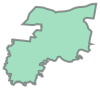

In [6]:
LGA_FEATURES_LIST[0]["geometry"]["coordinates"][0]

In [12]:
output = open('LGA_list.pkl','wb')
pickle.dump(LGA_FEATURES_LIST, output)
output.close()

In [13]:
input = open('LGA_list.pkl','rb')
lga_list = pickle.load(input)
input.close()

In [14]:
lga_list == LGA_FEATURES_LIST

True

In [7]:
data1 = add_lga_tags('LGA_list.pkl', data1)

in LGA Melbourne City 24600
Melbourne City


## Error handle test

In [1]:
import tweepy
import pickle

In [2]:
BEARER_TOKEN = ["AAAAAAAAAAAAAAAAAAAAABTzbAEAAAAAdojtSeSLrMbP1332MUDWvDH%2BizY%3DMTbgi5FKJHNnLwwO5acTPNP3uWRPrUAtoxnckAzXiDq3BwU4Bo",
    "AAAAAAAAAAAAAAAAAAAAAN%2FIbQEAAAAAsOzq2imuYFShxFO1EnN4EcOEA6c%3DMgCTYsVUpitvOTzwJFpMDCOvSPb2K5PNOjE1kLxnaTGXSPw462"]

query2 = 'hallucination OR insanity OR (mental disorder) OR (mental disease) OR (mental sickness) OR (mental health) OR (nervous disorder) OR neurosis lang:en'
query3 = '(neurotic disorder) OR (personality disorder) OR schizophrenia OR self-harm OR (self harm) OR suicide lang:en'

client = tweepy.Client(bearer_token= BEARER_TOKEN[0])

In [51]:
tweets = client.search_recent_tweets(query=query3, tweet_fields=['author_id', 'created_at', 'geo'], max_results=100)

In [60]:
count = 0
tweets = []
while(True):
    tweets += (client.search_recent_tweets(query=query3, tweet_fields=['author_id', 'created_at', 'geo'], max_results=100) )
    count += 1
    if(count == 100):
        break

In [61]:
len(tweets)

400

In [58]:
a = 'sss'
s = 0
while(s < 100):
    try:
        s += int(a)
        s = s + 1
    except Exception as ee:
        a = '1'
    


In [59]:
s

100